# INFO
Here I try to separate two 2D normal distributions, some star clasters. \
Two different methods will be used: 
- Maximum likelihood estimation (MLE);
- EM (expectation-maximization) method. 

In [6]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

import numpy as np
import matplotlib.pyplot as plt 

from scipy.stats import norm, multivariate_normal
# from scipy.stats import multivariate_normal
from scipy.optimize import minimize



# Getting data

Getting the star distribution

In [2]:
limit_magnitude = 16
center_coord = SkyCoord('02h21m00s +57d07m42s')
target_size = 0.5
range_ra = (center_coord.ra.degree - target_size / np.cos(center_coord.dec.radian),
            center_coord.ra.degree + target_size / np.cos(center_coord.dec.radian))
range_dec = (center_coord.dec.degree - target_size, center_coord.dec.degree + target_size)
query = '''
    SELECT ra, dec, pmra, pmdec 
    FROM gaiadr3.gaia_source 
    WHERE phot_bp_mean_mag < {:.2f} 
        AND pmra IS NOT NULL 
        AND pmdec IS NOT NULL 
        AND ra BETWEEN {:} AND {:} 
        AND dec BETWEEN {:} AND {:}
'''.format(limit_magnitude, *range_ra, *range_dec)

job = Gaia.launch_job_async(query)
stars = job.get_results()
ra = np.asarray(stars['ra']._data)
dec = np.asarray(stars['dec']._data)
pmra = np.asarray(stars['pmra']._data)
pmdec = np.asarray(stars['pmdec']._data)

INFO: Query finished. [astroquery.utils.tap.core]


Visualisation

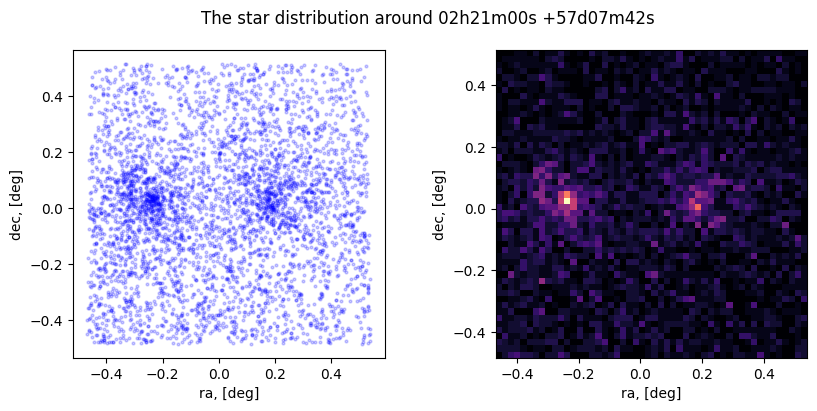

In [3]:
x1 = (ra - ra.mean()) * np.cos(dec / 180 * np.pi) # straightening (spherical coord. -> cartesian)
y1 = dec - dec.mean()


fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

fig.suptitle('The star distribution around 02h21m00s +57d07m42s')

axes[0].plot(x1, y1, '.', ms=4, color='blue', alpha=.2)
axes[1].hist2d(x1, y1, bins=50, cmap='magma')

histo = np.histogram2d(x1, y1, bins=40)

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.set_xlabel(r'ra, [deg]')
    ax.set_ylabel(r'dec, [deg]')


# Method realisation for 1D data

## Methods

MLE

In [44]:
def max_likelihood(x, tau, mu0, sigma0, mu1, sigma1):
    def neg_log_likelihood(theta):
        t, m0, s0, m1, s1 = theta
        log_p0 = norm.logpdf(x, m0, s0) + np.log(t)
        log_p1 = norm.logpdf(x, m1, s1) + np.log(1 - t)
        return -np.sum(np.logaddexp(log_p0, log_p1))

    bounds = [
        (1e-10, 1-1e-10),  # tau in (0,1)
        (None, None),      # mu0
        (1e-10, None),     # sigma0 > 0
        (None, None),      # mu1
        (1e-10, None)      # sigma1 > 0
    ]

    res = minimize(neg_log_likelihood, [tau, mu0, sigma0, mu1, sigma1], bounds=bounds)
    
    return res.x

EM

In [5]:
def em_double_gauss(x, tau, mu1, sigma1, mu2, sigma2, max_iter=100):
    for _ in range(max_iter):
        # E-step
        p1 = tau * norm.pdf(x, mu1, sigma1)
        p2 = (1 - tau) * norm.pdf(x, mu2, sigma2)
        total = p1 + p2

        gamma1 = p1 / total
        gamma2 = p2 / total

        # M-step
        sum_gamma1, sum_gamma2 = np.sum(gamma1), np.sum(gamma2)
        tau = sum_gamma1 / len(x)
        mu1 = np.sum(gamma1 * x) / sum_gamma1
        mu2 = np.sum(gamma2 * x) / sum_gamma2
        sigma1 = np.sqrt(np.sum(gamma1 * (x - mu1) ** 2) / sum_gamma1)
        sigma2 = np.sqrt(np.sum(gamma2 * (x - mu2) ** 2) / sum_gamma2)

    return tau, mu1, sigma1, mu2, sigma2

## Test

MLE: 0.3272308225243027 -1.9609848219386694 0.7169303129411689 0.48414934819484245 0.9314596167220257
EM : 0.3272349635580998 -1.9609713874274284 0.7169329881401277 0.48416272494634094 0.931443873193054


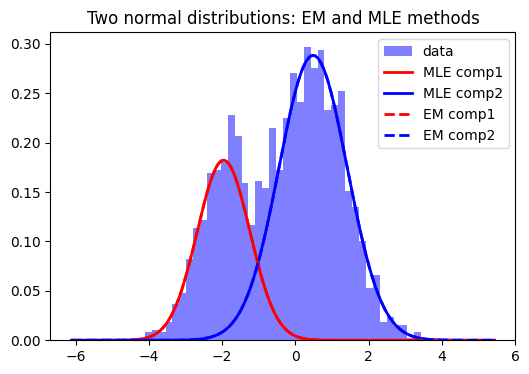

In [10]:
np.random.seed(42)

# True params 
tau_true = 0.3 # Share of one type of points
mu1_true, sigma1_true = -2, 0.7
mu2_true, sigma2_true = 0.5, 1.0

n = 2000
z = np.random.rand(n) < tau_true
x = np.where(z,
             np.random.normal(mu1_true, sigma1_true, n),
             np.random.normal(mu2_true, sigma2_true, n))

# Parameters estimation
params_mle = max_likelihood(x, 0.5, -1, 1, 1, 1)
params_em  = em_double_gauss(x, 0.5, -1, 1, 1, 1, max_iter=200)

print("MLE:", *params_mle)
print("EM :", *params_em)

# Visualization 
xs = np.linspace(min(x)-2, max(x)+2, 500)

plt.figure(figsize=(6,4))
plt.hist(x, bins=40, density=True, alpha=0.5, color="blue", label="data")

# MLE
tau, m0, s0, m1, s1 = params_mle
plt.plot(xs, tau*norm.pdf(xs, m0, s0), 'r-', lw=2, label="MLE comp1")
plt.plot(xs, (1-tau)*norm.pdf(xs, m1, s1), 'b-', lw=2, label="MLE comp2")

# EM
tau, m0, s0, m1, s1 = params_em
plt.plot(xs, tau*norm.pdf(xs, m0, s0), 'r--', lw=2, label="EM comp1")
plt.plot(xs, (1-tau)*norm.pdf(xs, m1, s1), 'b--', lw=2, label="EM comp2")

plt.legend()
plt.title("Two normal distributions: EM and MLE methods")
plt.show()

# 2D realization

I assume that covariance matrix of the normal distributions $\hat\Sigma = \sigma^2 \hat 1$  

2D MLE

In [117]:
def max_likelihood_2d(x, tau, mu0, sigma0, mu1, sigma1):
    def neg_log_likelihood(theta):
        t, m0x, m0y, s0, m1x, m1y, s1 = theta
        mu0 = np.array([m0x, m0y])
        mu1 = np.array([m1x, m1y])
        cov0 = s0**2 * np.identity(2)
        cov1 = s1**2 * np.identity(2)

        log_p0 = multivariate_normal.logpdf(x, mu0, cov0) + np.log(t)
        log_p1 = multivariate_normal.logpdf(x, mu1, cov1) + np.log(1 - t)
        return -np.sum(np.logaddexp(log_p0, log_p1))

    bounds = [
        (1e-10, 1-1e-10),  # tau
        (None, None),      # mu0_x
        (None, None),      # mu0_y
        (1e-10, None),     # sigma0
        (None, None),      # mu1_x
        (None, None),      # mu1_y
        (1e-10, None)      # sigma1
    ]

    init = [tau, mu0[0], mu0[1], sigma0, mu1[0], mu1[1], sigma1]
    res = minimize(neg_log_likelihood, init, bounds=bounds)

    tau, m0x, m0y, sigma0, m1x, m1y, sigma1 = res.x
    mu0 = np.array([m0x, m0y])
    mu1 = np.array([m1x, m1y])

    return tau, mu0, sigma0, mu1, sigma1

2D EM

In [114]:
def em_double_gauss_2d(x, tau, mu1, sigma1, mu2, sigma2, max_iter=100):
    for _ in range(max_iter):
        # E-step
        cov1 = sigma1**2 * np.identity(2)
        cov2 = sigma2**2 * np.identity(2)

        p1 = tau * multivariate_normal.pdf(x, mu1, cov1)
        p2 = (1 - tau) * multivariate_normal.pdf(x, mu2, cov2)
        total = p1 + p2

        gamma1 = p1 / total
        gamma2 = p2 / total

        # M-step
        sum_gamma1, sum_gamma2 = np.sum(gamma1), np.sum(gamma2)
        tau = sum_gamma1 / len(x)

        mu1 = np.sum(gamma1[:, None] * x, axis=0) / sum_gamma1
        mu2 = np.sum(gamma2[:, None] * x, axis=0) / sum_gamma2

        sigma1 = np.sqrt(np.sum(gamma1 * np.sum((x - mu1)**2, axis=1)) / (2 * sum_gamma1))
        sigma2 = np.sqrt(np.sum(gamma2 * np.sum((x - mu2)**2, axis=1)) / (2 * sum_gamma2))

    return tau, mu1, sigma1, mu2, sigma2

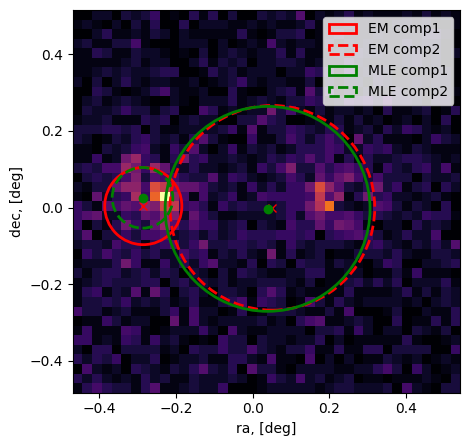

In [ ]:
# Stacking of data
x = np.vstack([x1, y1]).T

# Estimation
tau_em, mu1_em, sigma1_em, mu2_em, sigma2_em = em_double_gauss_2d(
    x, tau=0.5, mu1=np.array([0, 0]), sigma1=1.0,
    mu2=np.array([1, 1]), sigma2=1.0, max_iter=200
)

tau_mle, mu1_mle, sigma1_mle, mu2_mle, sigma2_mle = max_likelihood_2d(
    x, tau=0.5, mu0=np.array([0, 0]), sigma0=1.0,
    mu1=np.array([1, 1]), sigma1=1.0
)

# Visualizaion
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect("equal")

# 2D-гистограмма
ax.hist2d(x[:, 0], x[:, 1], bins=40, cmap="inferno")
ax.set_aspect('equal')
ax.set_xlabel(r'ra, [deg]')
ax.set_ylabel(r'dec, [deg]')

# EM
circle_em1 = plt.Circle(mu1_em, sigma1_em, fill=False, color="red", linewidth=2, label="EM comp1")
circle_em2 = plt.Circle(mu2_em, sigma2_em, fill=False, color="red", linewidth=2, linestyle="--", label="EM comp2")
ax.add_patch(circle_em1)
ax.add_patch(circle_em2)
ax.plot(*mu1_em, "x", color="red")
ax.plot(*mu2_em, "x", color="red")

# MLE
circle_mle1 = plt.Circle(mu1_mle, sigma1_mle, fill=False, color="green", linewidth=2, label="MLE comp1")
circle_mle2 = plt.Circle(mu2_mle, sigma2_mle, fill=False, color="green", linewidth=2, linestyle="--", label="MLE comp2")
ax.add_patch(circle_mle1)
ax.add_patch(circle_mle2)
ax.plot(*mu1_mle, "o", color="green")
ax.plot(*mu2_mle, "o", color="green")

ax.legend()
plt.show()